# PR-028 DenseNet

김성훈 교수님의 [DenseNet 강의](https://www.youtube.com/watch?v=fe2Vn0mwALI) 감사드립니다.

CIFAR10 데이터를 DenseNet 으로 학습시킵니다.

논문: https://arxiv.org/abs/1608.06993

### Prerequisite

<code> pip install opencv-python</code>

<code> pip install scikit-learn</code>

### Data Set
케라스에서는 손쉽게 CIFAR-10 데이터를 쓸 수 있도록 api를 제공해 줍니다.

또한 [data generator](https://keras.io/preprocessing/image/)를 이용하여 augmentation을 쉽게 사용할 수 있습니다.

In [1]:
import numpy as np

from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical

from sklearn.model_selection import train_test_split

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# normalization
x_train = np.array(x_train) / 127.5 - 1
x_test = np.array(x_test) / 127.5 - 1

# one-hot encoding
y_train = np.array(y_train)
y_test = np.array(y_test)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# train data의 1/4을 validation set으로 활용합니다.
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2)

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Build Model

논문에서는 크게 아래 사진과 같이 4개의 구조를 만들었습니다.

![image.png](DenseNet.png)

DenseNet-121 을 조금만 변형해서 사용해 봅니다.

input_shape 를 (32, 32, 3) 으로 입력시켜 주고

끝에 붙는 fully connected layer 의 크기를 10 으로 사용합니다.

In [2]:
from keras.models import Model
from keras.regularizers import l2
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import concatenate
from keras.layers import Conv2D, Activation, Input, Dense
from keras.layers.pooling import MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam

# hyperparameters
K = 32
init_ch = 64         # 가장 첫 layer의 채널 수 입니다.
compression = 0.5    # transition layer 에서의 channel을 얼마나 줄일 것인지 비율입니다. 논문에서도 0.5를 사용하였습니다.
inp_shape = (32, 32, 3)


# conv_layer를 간편하게 쓰기 위해 wrapper 입니다.
def conv_layer(x, filters, k, s):
    return Conv2D(filters,
                  kernel_size=(k, k),
                  strides=(s, s),
                  padding='same',
                  kernel_regularizer=l2(0.01))(x)

def dense_block(x, dense_block_size):
    for i in range(dense_block_size):
        tmp = x
        
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = conv_layer(x, 4*K, 1, 1)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = conv_layer(x, K, 3, 1)
        
        x = concatenate([x, tmp])
        
    return x

def transition_block(x):
    shape = x.get_shape().as_list()                    # output 의 shape을 가져옵니다.
    compressed_channels = int(shape[3] * compression)  # compression 비율만큼 channel을 줄여 줍니다.
    
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = conv_layer(x, compressed_channels, 1, 1)
    x = AveragePooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    
    return x

input_img = Input(inp_shape)

x = conv_layer(input_img, init_ch, 7, 2)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

x = dense_block(x, 6)
x = transition_block(x)

x = dense_block(x, 12)
x = transition_block(x)

x = dense_block(x, 24)
x = transition_block(x)

x = dense_block(x, 16)

x = GlobalAveragePooling2D()(x)
x = Dense(10, activation='softmax')(x)

dense121 = Model(input_img, x)

### Train Model

In [3]:
# callbacks
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
import math

def lr_schedule(epoch):
    return max(5e-5, 5e-4 * math.pow(0.7, epoch // 5))

lr_scheduler = LearningRateScheduler(lr_schedule)
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
checkpoint = ModelCheckpoint(filepath='model_{epoch:02d}.h5', 
                             save_best_only=True, 
                             save_weights_only=True)

In [4]:
dense121.compile(optimizer=Adam(0.0), loss='categorical_crossentropy', metrics=['accuracy'])

history = dense121.fit_generator(datagen.flow(x_train, y_train, batch_size=32),
                                 steps_per_epoch=x_train.shape[0] // 32,
                                 validation_data=datagen.flow(x_val, y_val, batch_size=8),
                                 validation_steps=x_val.shape[0] // 8,
                                 epochs = 100,
                                 callbacks=[early_stopping, checkpoint, lr_scheduler])

Epoch 1/100
1250/1250 [==============================] - 160s 128ms/step - loss: 19.9612 - acc: 0.3619 - val_loss: 2.2288 - val_acc: 0.4203
Epoch 2/100
1250/1250 [==============================] - 120s 96ms/step - loss: 1.9897 - acc: 0.4339 - val_loss: 2.0324 - val_acc: 0.4056
Epoch 3/100
1250/1250 [==============================] - 120s 96ms/step - loss: 1.8500 - acc: 0.4605 - val_loss: 2.0609 - val_acc: 0.3833
Epoch 4/100
1250/1250 [==============================] - 120s 96ms/step - loss: 1.7824 - acc: 0.4829 - val_loss: 2.3295 - val_acc: 0.3079
Epoch 5/100
1250/1250 [==============================] - 120s 96ms/step - loss: 1.7295 - acc: 0.5075 - val_loss: 2.2372 - val_acc: 0.3850
Epoch 6/100
1250/1250 [==============================] - 120s 96ms/step - loss: 1.5625 - acc: 0.5473 - val_loss: 1.6867 - val_acc: 0.5101
Epoch 7/100
1250/1250 [==============================] - 120s 96ms/step - loss: 1.5053 - acc: 0.5672 - val_loss: 1.6796 - val_acc: 0.5012
Epoch 8/100
1250/1250 [=========

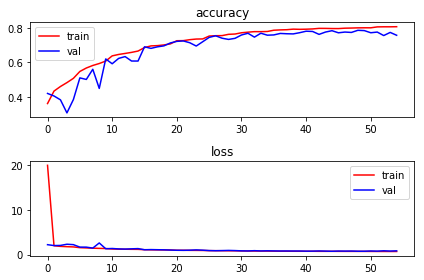

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.subplot(211)
plt.title("accuracy")
plt.plot(history.history["acc"], color="r", label="train")
plt.plot(history.history["val_acc"], color="b", label="val")
plt.legend(loc="best")

plt.subplot(212)
plt.title("loss")
plt.plot(history.history["loss"], color="r", label="train")
plt.plot(history.history["val_loss"], color="b", label="val")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

### Evaluate Model

In [7]:
score = dense121.evaluate(x_test, y_test)

print('test score:', score[0])
print('test accuracy:', score[1])

10000/10000 [==============================] - 5s 517us/step
test score: 0.7498723788738251
test accuracy: 0.7979


### Tip!

[keras application](https://keras.io/applications/#densenet)의 densenet을 사용하면 매우 편리하게 imagenet으로 학습된 모델을 가져올 수 있습니다.

In [8]:
from keras.applications import densenet

model = densenet.DenseNet121()

34119680/34115984 [==============================] - 97s 3us/step


## Contact me
케라스를 사랑하는 개발자 입니다.

질문, 조언, contribtuion 등 소통은 언제나 환영합니다.

Anthony Kim(김동현) : artit.anthony@gmail.com